# Régression linéaire avec TensorFlow

Dans ce notebook, nous allons apprendre à utiliser TensorFlow pour entraîner un modèle de régression linéaire sur le jeu de données Boston de Scikit-learn. L'objectif est de prédire le prix des maisons à partir de leurs caractéristiques.

## Importation des packages

In [1]:
pip install scikit-learn==1.1

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import SGD

## Importation des données

In [3]:
boston = load_boston()
X = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])

X_train, X_test, y_train, y_test = train_test_split(X, boston['target'], test_size=0.33, random_state=42)

std_scaler = StandardScaler().fit(X_train, y_train)

X_train  =  std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

X_train_tf = tf.convert_to_tensor(X_train)
X_test_tf = tf.convert_to_tensor(X_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

## Création de l'architecture

La fonction `Dense` permet d'initialiser les poids pour la régression linéaire et d'effectuer une multiplication matricielle entre les poids et les exemples d'entraînement. Utilisez les paramètres `units` et `input_shape` pour spécifier le nombre d'entrées et de sorties de la couche.

Pour plus d'informatons, n'hésitez pas à lire la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

La fonction `Dense` sera déclarée dans un modèle via la fonction `Sequential`.

Pour plus d'informatons, n'hésitez pas à lire la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).


In [4]:
def linear_regression(input_shape:int, output_shape:int)->tf.keras.models.Sequential:
  model = Sequential([Dense(input_shape=(input_shape,), units=output_shape)])
  return model

Initialiser notre modèle.

In [5]:
rl_model = linear_regression(input_shape=13, output_shape=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
rl_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              14 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Prédire notre jeu d'entraînement.

Utilisez la méthode `predict` du modèle pour appliquer le modèle sur le jeu de données `X_train_tf`.

In [7]:
prediction = rl_model.predict(X_train_tf)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [8]:
mean_absolute_error(prediction, y_train)

22.970796475341892

## Définir la fonction de coût

Vous allez maintenant initialiser votre fonction de coût.

Vous pouvez consulter les différentes fonctions de coût implémentées par TensorFlow dans la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses).

Pour ce notebook utilisez `MeanAbsoluteError`.

In [9]:
loss = MeanAbsoluteError()

## Définir l'algorithme d'optimisation

Vous allez maintenant initialiser votre fonction d'optimisation, qui aura pour rôle de mettre à jour les poids du modèle. Il existe des variantes de la descente de gradient, conçues pour être plus rapides et performantes.

Vous pouvez consulter les différents algorithmes d'optimisation implémentés par TensorFlow dans la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).

Dans ce notebook, vous allez utiliser la descente de gradient stochastique, l'algorithme de base appelé `SGD` dans TensorFlow.

In [10]:
opt = SGD(learning_rate=0.1)

## Définir la fonction d'entraînement

Nous allons maintenant initialiser la fonction d'entraînement de notre modèle en utilisant notre modèle, notre fonction de coût et notre algorithme d'optimisation.

In [11]:
def step(model:tf.keras.models.Sequential, opt:tf.keras.optimizers, loss:tf.keras.losses, x_train:np.ndarray, y_train:np.ndarray)->tuple:

  # garder la trace de nos gradients
  with tf.GradientTape() as tape:
    # faire une prédiction en utilisant le modèle, puis calculer le coût
	  pred = model(x_train)
	  train_loss = loss(y_train, pred)

	# calculer les gradients en utilisant tape
  grads = tape.gradient(train_loss, model.trainable_variables)

  # mettre à jour les poids du modèle
  opt.apply_gradients(zip(grads, model.trainable_variables))

  return model, train_loss

## Entraîner notre modèle

Il est maintenant temps d'entraîner notre modèle

In [12]:
epoch = 1000
history_train = []
history_test = []

for e in range(epoch) :

  # mise à jour des poids
  rl_model, train_loss = step(rl_model, opt, loss, X_train_tf, y_train_tf)

  # prédiction sur le jeu de test
  test_pred = rl_model(X_test_tf)
  test_loss = mean_absolute_error(test_pred, y_test)

  # sauvegarde des coûts
  history_train = np.append(history_train, train_loss)
  history_test = np.append(history_test, test_loss)

  print('train_loss : '+str(np.squeeze(train_loss))+ ' test_loss : '+str(test_loss))


train_loss : 22.970797 test_loss : 21.387806539987015
train_loss : 22.870796 test_loss : 21.287806535864657
train_loss : 22.770794 test_loss : 21.187806567299862
train_loss : 22.670795 test_loss : 21.08780655693151
train_loss : 22.570797 test_loss : 20.98780655057844
train_loss : 22.470797 test_loss : 20.88780658134443
train_loss : 22.370796 test_loss : 20.78780660800591
train_loss : 22.270794 test_loss : 20.687806585413252
train_loss : 22.170795 test_loss : 20.587806558537626
train_loss : 22.070797 test_loss : 20.487806533625026
train_loss : 21.970797 test_loss : 20.387806509783168
train_loss : 21.870796 test_loss : 20.287806487368965
train_loss : 21.770794 test_loss : 20.187806460671798
train_loss : 21.670795 test_loss : 20.087806438257594
train_loss : 21.570797 test_loss : 19.98780642084019
train_loss : 21.470797 test_loss : 19.88780639592759
train_loss : 21.370796 test_loss : 19.787806362092137
train_loss : 21.270794 test_loss : 19.687806341819417
train_loss : 21.170795 test_loss :

Visualisation de l'évolution du coût pendant l'entraînement.

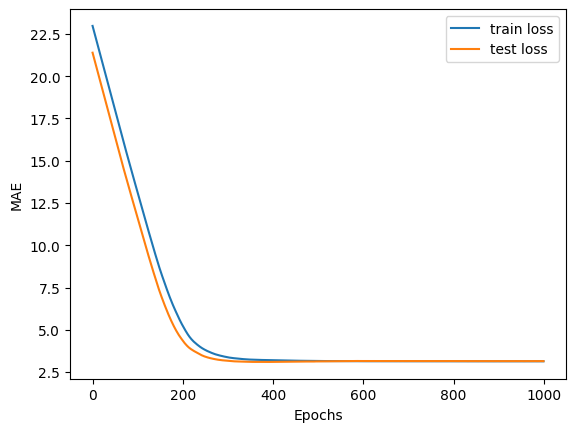

In [13]:
plt.plot(np.arange(epoch), history_train, label='train loss')
plt.plot(np.arange(epoch), history_test, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Sauvegarde du modèle

Maintenant que notre modèle est entraîné, il est temps de le sauvegarder.

Sauvegarder les poids du modèle grâce à la méthode `save_weights`

In [14]:
rl_model.save_weights('linear_regression.weights.h5')

Remplacez le modèle entraîné par un nouveau modèle dont les poids sont initialisés aléatoirement.

In [15]:
rl_model = linear_regression(input_shape=13, output_shape=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
prediction = rl_model(X_train_tf)
mean_absolute_error(prediction, y_train)

22.970796445605504

Étant donné que les poids du modèle sont initialisés de manière aléatoire, les performances sont faibles.

Nous pouvons restaurer nos poids entraînés en chargeant les poids précédemment sauvegardés.

In [17]:
rl_model.load_weights('linear_regression.weights.h5')

In [18]:
prediction = rl_model(X_train_tf)
mean_absolute_error(prediction, y_train)

3.1391412031685713

Maintenant que les poids du modèle entraîné ont été chargés, la performance du modèle est nettement améliorée.